# Introdução

Antes de iniciar na área de migrar de carreira para Cientista de Dados eu trabalhava como Técnico em Segurança do Trabalho em uma Universidade Federal. O local onde eu trabalhava não era um local muito tecnologico e muitos processos eram morosos pois era necessário copiar e colar informações de diferentes fontes em um único documento.

Uma informação muito importante quando se está desenvolvendo documentos na área de Segurança no Trabalho é a descrição das atividades dos cargos. Atualmente a única fonte disponível com essa informação é o PCCTAE (Plano de Carreira dos Cargos Técnico-Administrativos em Educação).

No PCCTAE temos níveis dos cargos que vão de A até E, cada nível contém um pdf com algumas informações de cada cargo daquele nível. Na figura abaixo podemos ver o exemplo para o cargo "Assistente de Estúdio".

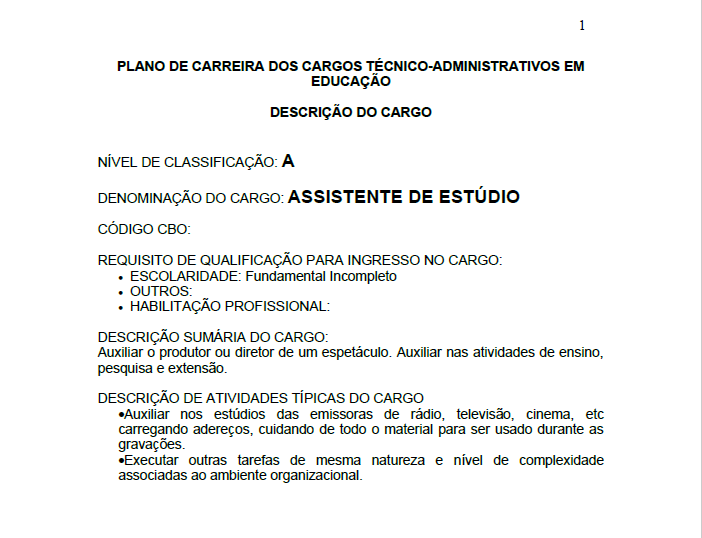

O problema é que toda vez que é necessário consultar a descrição dos cargos, o servidor tem que lembrar qual o nível de cada cargo, abrir um pdf, procurar pelo cargo, copiar a descrição e depois colar a descrição no documento que ele está elaborando.

Para resolver esse problema vamos criar um código em python para ler os 5 arquivos pdf, extrair as informações importantes, limpar os dados e gerar um arquivo excel.

Vamos fazer esse projeto utilizando a linguagem python e as seguintes bibliotecas:


- pandas: Não necessita apresentações, biblioteca mais usada em python para manipulação de dados.

- tika : É a versão python para o Apache Tika. Essa ferramenta permite extrair textos de arquivos com formatos variados. Vamos utilizar no nosso projeto para ler o pdf.

- parser : Essa lib faz algo sensacional, ela implementa o contrário do .format(). Então ela te permite apartir de um padrão recuperar informações de strings. Vamos usar para extrair as informações que queremos.

- great expectations: É uma biblioteca em python para Data Quality. Vamos utilizar para ver a qualidade dos dados após o processo de coleta dos dados.

# Importar Bibliotecas

In [1]:
from parse import findall,search
from tika import parser
import pandas as pd
import os
import re
import great_expectations as ge

# Os arquivos PDF

Eu coloquei eles em uma pasta no projeto chamada "pdfs". O objetivo do código abaixo é utilizar a biblioteca os para criar uma lista com o nome dos 5 arquivos. A função os.listdir apenas retorna uma lista com o nome de todos os arquivos em uma pasta.

In [2]:
list_pdf = os.listdir("pdfs")

In [3]:
list_pdf

['DESCRICAO_DE_CARGOS-NIVEL_A.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_B.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_C.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_D.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_E.pdf']

# Extraindo texto do PDF

Para extrair o texto de um PDF vamos utilizar a função parser.from_file() do apache tika. O que ela faz é literalmente transformar o arquivo que você passa o caminho como parametro e ele retorna o texto desse arquivo. Abaixo fazemos o teste com o primeiro pdf.

In [4]:
raw = parser.from_file(f"pdfs\{list_pdf[-1]}")
text = raw['content']

<>:1: DeprecationWarning: invalid escape sequence \{
<>:1: DeprecationWarning: invalid escape sequence \{
C:\Users\THFURT~1\AppData\Local\Temp/ipykernel_65248/1276913374.py:1: DeprecationWarning: invalid escape sequence \{
  raw = parser.from_file(f"pdfs\{list_pdf[-1]}")


In [5]:
text = text.strip('\n')

In [6]:
text

'PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM EDUCAÇÃO\n\n\nPLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM \nEDUCAÇÃO\n\nDESCRIÇÃO DO CARGO\n\nNÍVEL DE CLASSIFICAÇÃO: E\n\nDENOMINAÇÃO DO CARGO: ADMINISTRADOR\n\nCÓDIGO CBO: 2521-05\n\nREQUISITO DE QUALIFICAÇÃO PARA INGRESSO NO CARGO:\n• ESCOLARIDADE: Curso Superior em Administração\n• OUTROS:\n• HABILITAÇÃO PROFISSIONAL: Decreto nº 61.934 - de 22 de dezembro de \n\n1967 dispõe  sobre  a  regulamentação  de  exercício  da  profissão  de \nAdministrador, de acordo com a Lei nº 4.769, de 09 de setembro de 1965. \nRegistro no Conselho competente.\n\nDESCRIÇÃO SUMÁRIA DO CARGO:\nPlanejar, organizar, controlar e assessorar as organizações nas áreas de recursos \nhumanos, patrimônio, materiais, informações, financeira, tecnológica, entre outras; \nimplementar  programas  e  projetos;  elaborar  planejamento  organizacional; \npromover  estudos de racionalização e controlar  o  desempenho organizacional. \nPrestar  consultor

# Coletando as Informações

Note que a variável text é uma string enorme que contém informações textuais do PDF. Como não estamos interessados em todas as informações, vamos utilizar a função findall() para achar todas as ocorrências que queremos.

Lembra que eu disse que o parser era o contrário do .format()? A forma de pensar é exatamente essa. Por exemplo, o {nivel} vai pegar todo o texto que está depois de "NÍVEL DE CLASSIFICAÇÃO: "  e "DENOMINAÇÃO DO CARGO".

In [7]:
query_search = '''
NÍVEL DE CLASSIFICAÇÃO: {nivel}\n\nDENOMINAÇÃO DO CARGO: {cargo}\n\nCÓDIGO CBO: {cbo}\n\nREQUISITO DE QUALIFICAÇÃO PARA INGRESSO NO CARGO:\n{requisitos}DESCRIÇÃO SUMÁRIA DO CARGO:\n{descricao}\n\nDESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO
'''

Como queremos encontrar o padrão mais de uma vez, utilizaremos o findall(). Caso você queira encontrar apenas uma vez, utilize o search(). Aqui eu só limitei o print até 4 resultados para não poluir muito.

In [8]:
for i,infos_raw in enumerate(findall(query_search, text)):
    print(f"{i} - cargo: {infos_raw['cargo']}")
    
    if i >= 3:
        break

0 - cargo: ADMINISTRADOR
1 - cargo: ANTROPÓLOGO
2 - cargo: ARQUEÓLOGO
3 - cargo: ARQUITETO E URBANISTA


# Função que gera os Datasets

Vamos fazer os testes de todos os passos que precisamos com um PDF e depois criaremos uma função para lidar com os outros.

In [9]:
list_pdf

['DESCRICAO_DE_CARGOS-NIVEL_A.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_B.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_C.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_D.pdf',
 'DESCRICAO_DE_CARGOS-NIVEL_E.pdf']

In [10]:
raw = parser.from_file(f"pdfs\{list_pdf[0]}")
text = raw['content']
text = re.sub(r"\n",' ',text)
print(text)

                                       PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM EDUCAÇÃO   PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM  EDUCAÇÃO  DESCRIÇÃO DO CARGO  NÍVEL DE CLASSIFICAÇÃO: A  DENOMINAÇÃO DO CARGO: ASSISTENTE DE ESTÚDIO  CÓDIGO CBO:  REQUISITO DE QUALIFICAÇÃO PARA INGRESSO NO CARGO: • ESCOLARIDADE: Fundamental Incompleto • OUTROS: • HABILITAÇÃO PROFISSIONAL:  DESCRIÇÃO SUMÁRIA DO CARGO: Auxiliar o produtor ou diretor de um espetáculo. Auxiliar nas atividades de ensino,  pesquisa e extensão.  DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO •Auxiliar  nos  estúdios  das  emissoras  de  rádio,  televisão,  cinema,  etc  carregando adereços, cuidando de todo o material para ser usado durante as  gravações. •Executar  outras  tarefas  de  mesma  natureza  e  nível  de  complexidade  associadas ao ambiente organizacional.  1    PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM  EDUCAÇÃO  DESCRIÇÃO DO CARGO  NÍVEL DE CLASSIFICAÇÃO: A  DENOMINAÇÃO DO 

<>:1: DeprecationWarning: invalid escape sequence \{
<>:1: DeprecationWarning: invalid escape sequence \{
C:\Users\THFURT~1\AppData\Local\Temp/ipykernel_65248/739113550.py:1: DeprecationWarning: invalid escape sequence \{
  raw = parser.from_file(f"pdfs\{list_pdf[0]}")


Note que existe um pedaço do texto entre as informações que eu quero (nível, cargo, cbo e descrição). Vamos retirar esse pedaço de texto inútil utilizando regex.

In [11]:
text_clean = re.sub('REQUISITO DE QUALIFICAÇÃO PARA INGRESSO NO CARGO:.*?DESCRIÇÃO SUMÁRIA DO CARGO','DESCRICAO ', text, flags=re.DOTALL)

In [12]:
text_clean

'                                       PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM EDUCAÇÃO   PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM  EDUCAÇÃO  DESCRIÇÃO DO CARGO  NÍVEL DE CLASSIFICAÇÃO: A  DENOMINAÇÃO DO CARGO: ASSISTENTE DE ESTÚDIO  CÓDIGO CBO:  DESCRICAO : Auxiliar o produtor ou diretor de um espetáculo. Auxiliar nas atividades de ensino,  pesquisa e extensão.  DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO •Auxiliar  nos  estúdios  das  emissoras  de  rádio,  televisão,  cinema,  etc  carregando adereços, cuidando de todo o material para ser usado durante as  gravações. •Executar  outras  tarefas  de  mesma  natureza  e  nível  de  complexidade  associadas ao ambiente organizacional.  1    PLANO DE CARREIRA DOS CARGOS TÉCNICO-ADMINISTRATIVOS EM  EDUCAÇÃO  DESCRIÇÃO DO CARGO  NÍVEL DE CLASSIFICAÇÃO: A  DENOMINAÇÃO DO CARGO: AUXILIAR DE ALFAIATE  CÓDIGO CBO  DESCRICAO : Auxiliar nas tarefas de confecção de peças de vestuário. Auxiliar nas atividades de  ensin

In [13]:
text_clean = re.sub("CÓDIGO CBO","||CÓDIGO CBO", text_clean)
text_clean = re.sub("DENOMINAÇÃO DO CARGO","||DENOMINAÇÃO DO CARGO", text_clean)
text_clean = re.sub("DENOMINAÇÃO  DO  CARGO","||DENOMINAÇÃO DO CARGO", text_clean)
text_clean = re.sub("DESCRICAO","||DESCRICAO", text_clean)

Esse processamento é só para ajudar a função parser a descobrir onde ela tem que terminar de extrair a informação.

Note que agora eu tenho todas as informações que eu quero agrupadas, agora o que temos que fazer é retirar só a informação que queremos do resto do texto que é lixo, para isso usaremos regex de novo.

In [14]:
list_text_clean = re.findall('NÍVEL DE CLASSIFICAÇÃO.*?DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO', text_clean)
list_text_clean

['NÍVEL DE CLASSIFICAÇÃO: A  ||DENOMINAÇÃO DO CARGO: ASSISTENTE DE ESTÚDIO  ||CÓDIGO CBO:  ||DESCRICAO : Auxiliar o produtor ou diretor de um espetáculo. Auxiliar nas atividades de ensino,  pesquisa e extensão.  DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO',
 'NÍVEL DE CLASSIFICAÇÃO: A  ||DENOMINAÇÃO DO CARGO: AUXILIAR DE ALFAIATE  ||CÓDIGO CBO  ||DESCRICAO : Auxiliar nas tarefas de confecção de peças de vestuário. Auxiliar nas atividades de  ensino, pesquisa e extensão.  DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO',
 'NÍVEL DE CLASSIFICAÇÃO: A  ||DENOMINAÇÃO DO CARGO: AUXILIAR DE CARPINTARIA  ||CÓDIGO CBO  ||DESCRICAO : Auxiliar  em  todas  as  atividades  de  carpintaria  tais  como:  corte,  armação,  instalação e reparação de peças de madeira.  Auxiliar nas atividades de ensino,  pesquisa e extensão.  DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO',
 'NÍVEL DE CLASSIFICAÇÃO: A  ||DENOMINAÇÃO DO CARGO: AUXILIAR DE DOBRADOR  ||CÓDIGO CBO  ||DESCRICAO : Auxiliar  na  tarefa  de  dobramento  de  ch

pronto, agora temos uma lista com todos os pedaços de texto que gostariamos, agora é só interar por cima dessa lista e coletar as informações que queremos.

In [15]:
query_nivel = 'NÍVEL DE CLASSIFICAÇÃO:{nivel}||'
query_cbo = 'CÓDIGO CBO{cbo}||'
query_cargo = 'DENOMINAÇÃO DO CARGO:{cargo}||'
query_descricao = 'DESCRICAO :{descricao}DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO'

In [16]:
list_nivel = []
list_cargo = []
list_cbo = []
list_descricao = []
list_not_works = []
for i,text in enumerate(list_text_clean):
    
    info_nivel = search(query_nivel,text)
    info_cbo = search(query_cbo,text)
    info_cargo = search(query_cargo,text)
    info_descricao = search(query_descricao,text)
    
    nivel = info_nivel['nivel'] if info_nivel is not None else None
    cbo = info_cbo['cbo'] if info_cbo is not None else None
    cargo = info_cargo['cargo'] if info_cargo is not None else None
    descricao = info_descricao['descricao'] if info_descricao is not None else None
    
    list_nivel.append(nivel)
    list_cargo.append(cargo)
    list_cbo.append(cbo)
    list_descricao.append(descricao)
    

df_B = pd.DataFrame().from_dict({'nivel':list_nivel,'cargo':list_cargo,'cbo':list_cbo,'descricao':list_descricao})

In [17]:
df_B

,nivel,cargo,cbo,descricao
0,A,ASSISTENTE DE ESTÚDIO,:,Auxiliar o produtor ou diretor de um espetácu...
1,A,AUXILIAR DE ALFAIATE,,Auxiliar nas tarefas de confecção de peças de...
2,A,AUXILIAR DE CARPINTARIA,,Auxiliar em todas as atividades de carp...
3,A,AUXILIAR DE DOBRADOR,,Auxiliar na tarefa de dobramento de cha...
4,A,AUXILIAR DE ENCANADOR,,Desenvolver atividades auxiliares gerais de e...
5,A,AUXILIAR DE ESTOFADOR,,Auxiliar nas tarefas de colocação e rep...
6,A,AUXILIAR DE FORJADOR DE METAIS,,"Auxiliar nas tarefas de forjar barras, hastes..."
7,A,AUXILIAR DE FUNDIÇÃO DE METAIS,,Auxiliar nas tarefas de fundição de met...
8,A,AUXILIAR DE INFRA-ESTRUTURA E MANUTENÇÃO/ÁREA,,"Auxiliar nas tarefas de construção, tran..."
9,A,AUXILIAR DE LIMPEZA,,Executar trabalhos de limpeza em geral ...


Note que aparentemente está tudo correto com o DataFrame. Tem alguns dados que não foram preenchidos, outros que parecem um pouco estranhos mas depois utilizaremos o great expectations para avaliar todos os datasets juntos. Por agora só vamos criar a função que retira as informações necessárias dos PDF's,

In [18]:
def create_DataFrame_from_pdf_PCCTAE(path):
    '''
    Function to extract infos from PCCTAE pdf's.
    
    Params:
    path (string) - Path of files in your system
    
    Return
    df (pandas.DataFrame) - DataFrame with informations from pdf.
    
    '''
    
    # 1 - Transform extract text from pdf.
    raw = parser.from_file(path)
    text = raw['content']
    
    # 2 - Clean string
    text = re.sub(r"\n",' ',text)
    text_clean = re.sub('REQUISITO DE QUALIFICAÇÃO PARA INGRESSO NO CARGO:.*?DESCRIÇÃO SUMÁRIA DO CARGO','DESCRICAO ', text, flags=re.DOTALL)
    text_clean = re.sub("CÓDIGO CBO","||CÓDIGO CBO", text_clean)
    text_clean = re.sub("DENOMINAÇÃO DO CARGO","||DENOMINAÇÃO DO CARGO", text_clean)
    text_clean = re.sub("DENOMINAÇÃO  DO  CARGO","||DENOMINAÇÃO DO CARGO", text_clean)
    text_clean = re.sub("DESCRICAO","||DESCRICAO", text_clean)
    
    # 3 - Extract import part of string
    list_text_clean = re.findall('NÍVEL DE CLASSIFICAÇÃO.*?DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO', text_clean)
    
    # 4 - Define queries search
    query_nivel = 'NÍVEL DE CLASSIFICAÇÃO:{nivel}||'
    query_cbo = 'CÓDIGO CBO{cbo}||'
    query_cargo = 'DENOMINAÇÃO DO CARGO:{cargo}||'
    query_descricao = 'DESCRICAO :{descricao}DESCRIÇÃO DE ATIVIDADES TÍPICAS DO CARGO'
    
    # 5 - Run the loop

    list_nivel = []
    list_cargo = []
    list_cbo = []
    list_descricao = []
    list_not_works = []
    for i,text in enumerate(list_text_clean):

        info_nivel = search(query_nivel,text)
        info_cbo = search(query_cbo,text)
        info_cargo = search(query_cargo,text)
        info_descricao = search(query_descricao,text)

        nivel = info_nivel['nivel'] if info_nivel is not None else None
        cbo = info_cbo['cbo'] if info_cbo is not None else None
        cargo = info_cargo['cargo'] if info_cargo is not None else None
        descricao = info_descricao['descricao'] if info_descricao is not None else None

        list_nivel.append(nivel)
        list_cargo.append(cargo)
        list_cbo.append(cbo)
        list_descricao.append(descricao)

    # 6 - Generate df
    df = pd.DataFrame().from_dict({'nivel':list_nivel,'cargo':list_cargo,'cbo':list_cbo,'descricao':list_descricao})
    
    return df

# Criando um DataFrame

Agora que temos uma função que facilita o trabalho de gerar os dataset, para gerar um dataset único vamos iterar por toda lista de arquivos na pasta pdf's e depois concatenar eles.

In [19]:
df = pd.DataFrame(columns=['nivel','cargo','cbo','descricao'])
for pdf in list_pdf:
    path = f'pdfs/{pdf}'
    
    df_per_nivel = create_DataFrame_from_pdf_PCCTAE(path)
    
    df = pd.concat([df,df_per_nivel])
    print(df.shape)

(30, 4)
(88, 4)
(100, 4)
(167, 4)
(240, 4)


In [20]:
df

,nivel,cargo,cbo,descricao
0,A,ASSISTENTE DE ESTÚDIO,:,Auxiliar o produtor ou diretor de um espetácu...
1,A,AUXILIAR DE ALFAIATE,,Auxiliar nas tarefas de confecção de peças de...
2,A,AUXILIAR DE CARPINTARIA,,Auxiliar em todas as atividades de carp...
3,A,AUXILIAR DE DOBRADOR,,Auxiliar na tarefa de dobramento de cha...
4,A,AUXILIAR DE ENCANADOR,,Desenvolver atividades auxiliares gerais de e...
...,...,...,...,...
68,E,TÉNICO EM ASSUNTOS EDUCACIONAIS,:,"Coordenar as atividades de ensino, planejamen..."
69,E,TECNÓLOGO EM COOPERATIVISMO,:,"Planejar, coordenar e supervisionar ativi..."
70,E,TECNÓLOGO / FORMAÇÃO,:,"Estudar, planejar, projetar, especificar e ex..."
71,E,TERAPEUTA OCUPACIONAL,: 2236-20,"Atender pacientes para prevenção, habilitação..."


In [21]:
df.to_csv("dados/df_raw.csv", index=False, sep=';')

Salvamos os dados na pasta dados como csv, no próximo passo iremos abrir esse arquivo csv pelo great expectations.

# Data Quality do DataFrame criado

Bem, o processo de extração ocorreu, o número de cargos parece condizente com a realidade e agora temos que medir a qualidade desse DataFrame. Logo de cara já podemos observar que a coluna cbo é a mais complicada. Mas temos alguns outros testes para fazer como:

- Ver se a coluna nível apresenta apenas os valores A,B,C,D e E.

- Testar se na coluna cbo tem o padrão nnnn-nn ou nnnn.

In [22]:
df_raw = ge.read_csv("dados/df_raw.csv", sep=';')

In [23]:
df_raw

,nivel,cargo,cbo,descricao
0,A,ASSISTENTE DE ESTÚDIO,:,Auxiliar o produtor ou diretor de um espetácu...
1,A,AUXILIAR DE ALFAIATE,,Auxiliar nas tarefas de confecção de peças de...
2,A,AUXILIAR DE CARPINTARIA,,Auxiliar em todas as atividades de carp...
3,A,AUXILIAR DE DOBRADOR,,Auxiliar na tarefa de dobramento de cha...
4,A,AUXILIAR DE ENCANADOR,,Desenvolver atividades auxiliares gerais de e...
...,...,...,...,...
235,E,TÉNICO EM ASSUNTOS EDUCACIONAIS,:,"Coordenar as atividades de ensino, planejamen..."
236,E,TECNÓLOGO EM COOPERATIVISMO,:,"Planejar, coordenar e supervisionar ativi..."
237,E,TECNÓLOGO / FORMAÇÃO,:,"Estudar, planejar, projetar, especificar e ex..."
238,E,TERAPEUTA OCUPACIONAL,: 2236-20,"Atender pacientes para prevenção, habilitação..."


In [24]:
df_raw.expect_column_values_to_be_in_set(column='nivel',value_set=['A','B','C','D','E'])

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 240,
    "unexpected_percent": 100.0,
    "unexpected_percent_total": 100.0,
    "unexpected_percent_nonmissing": 100.0,
    "partial_unexpected_list": [
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  ",
      " A  "
    ]
  },
  "meta": {}
}

O DataFrame já foi recusado no primeiro teste. Isso aconteceu porque quando extraímos a informação coletamos os espaços antes e depois do nível.

In [25]:
df_raw['nivel'] = df_raw['nivel'].apply(lambda x: x.strip(" "))

In [26]:
df_raw.expect_column_values_to_be_in_set(column='nivel',value_set=['A','B','C','D','E'])

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "result": {
    "element_count": 240,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "meta": {}
}

Após arrumar a coluna ela passou no teste.

In [27]:
df_raw.expect_column_values_to_match_regex(column='cbo',regex = "[^0-9][0-9]{4}-[0-9][^0-9]{2}")

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "missing_count": 2,
    "missing_percent": 0.8333333333333334,
    "unexpected_count": 238,
    "unexpected_percent": 100.0,
    "unexpected_percent_total": 99.16666666666667,
    "unexpected_percent_nonmissing": 100.0,
    "partial_unexpected_list": [
      ":  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      "  ",
      " \u2013 6326  ",
      "  "
    ]
  },
  "meta": {}
}

Nesse ponto já é um pouco mais complicado limpar. Primeiro temos que transformar tudo que está como "  " em null.

In [28]:
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == "  " else x)

In [29]:
df_raw.expect_column_values_to_match_regex(column='cbo',regex = "[0-9]|[0-9]-[0-9]|[0-9]-[0-9]&([0-9]-[0-9])*")

C:\Users\thfurtado\Anaconda3\envs\extractPDF\lib\site-packages\great_expectations\dataset\pandas_dataset.py:1391: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return column.astype(str).str.contains(regex)


{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "missing_count": 36,
    "missing_percent": 15.0,
    "unexpected_count": 73,
    "unexpected_percent": 35.78431372549019,
    "unexpected_percent_total": 30.416666666666664,
    "unexpected_percent_nonmissing": 35.78431372549019,
    "partial_unexpected_list": [
      ":  ",
      ":   ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " \u2013  ",
      " -   ",
      " -  ",
      " -  ",
      " -  ",
      " -  ",
      " -  ",
      " -  ",
      " -  ",
      " -  ",
      " -  "
    ]
  },
  "meta": {}
}

Já limpou um pouco mais, mas ainda temos sujeira nos dados, vamos testar retirar os " \u2013  ",":   " e ":  " e retirar os \u2013 do resto.

In [30]:
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == " \u2013  " else x)
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == ":   " else x)
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == ":  " else x)

In [31]:
df_raw['cbo'] = df_raw['cbo'].apply(lambda x: None if x == None else str(x).replace("\u2013",""))

In [35]:
df_raw.expect_column_values_to_match_regex(column='cbo',regex = "[0-9]|[0-9]-[0-9]|[0-9]-[0-9]&([0-9]-[0-9])*")

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "missing_count": 106,
    "missing_percent": 44.166666666666664,
    "unexpected_count": 3,
    "unexpected_percent": 2.2388059701492535,
    "unexpected_percent_total": 1.25,
    "unexpected_percent_nonmissing": 2.2388059701492535,
    "partial_unexpected_list": [
      "nan",
      ":",
      "nan"
    ]
  },
  "meta": {}
}

In [36]:
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == None else x.replace(" - ","").replace(" ",""))
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == "" else x)

In [37]:
df_raw.expect_column_values_to_match_regex(column='cbo',regex = "[0-9]|[0-9]-[0-9]|[0-9]-[0-9]&([0-9]-[0-9])*")

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "missing_count": 106,
    "missing_percent": 44.166666666666664,
    "unexpected_count": 3,
    "unexpected_percent": 2.2388059701492535,
    "unexpected_percent_total": 1.25,
    "unexpected_percent_nonmissing": 2.2388059701492535,
    "partial_unexpected_list": [
      "nan",
      ":",
      "nan"
    ]
  },
  "meta": {}
}

In [44]:
df_raw
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == None else x.replace(":",'').replace("nan","").replace("e","&"))
df_raw['cbo'] = df_raw['cbo'].apply(lambda x:None if x == "" else x)

In [45]:
df_raw.expect_column_values_to_match_regex(column='cbo',regex = "[0-9]|[0-9]-[0-9]|[0-9]-[0-9]&([0-9]-[0-9])*")

C:\Users\thfurtado\Anaconda3\envs\extractPDF\lib\site-packages\great_expectations\dataset\pandas_dataset.py:1391: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return column.astype(str).str.contains(regex)


{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "result": {
    "element_count": 240,
    "missing_count": 109,
    "missing_percent": 45.416666666666664,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "meta": {}
}

Dado que agora também limpamos a coluna de cbo, basta só salvar o arquivo com xlsx.

In [49]:
df_raw.to_excel("dados/Descricao_cargos_PCCTAE.xlsx")

In [50]:
df_raw.expect_column_values_to_not_be_null("descricao")

{
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": false,
  "result": {
    "element_count": 240,
    "unexpected_count": 2,
    "unexpected_percent": 0.8333333333333334,
    "unexpected_percent_total": 0.8333333333333334,
    "partial_unexpected_list": []
  },
  "meta": {}
}

# Conclusão

Obviamente o Dataset não saiu perfeito, ele não conseguiu extrair alguns cbo's e também não conseguiu extrair algumas descrições. 

No caso do CBO isso não é de todo um erro pois em muitos cargos o cbo não está preenchido no próprio pdf.

Quanto a descrição do cargo temos apenas dois cargos que não tiveram suas descrições coletadas, é mais fácil colocar na mão que mudar o código para coletar esses dois casos programaticamente. 

Essa planilha foi disponíbilizada para o pessoal do meu antigo trabalho e recebi feedbacks positivos quanto a deixar de coletar os dados no PDF e passar a utilizar a planilha.

O próximo passo é criar os documentos de forma programatica também.